# 개체 세그멘테이션 하기
1. 데이터 업로드 하기
2. 미리 학습시킨 세그멘테이션 모델 업로드하기
3. 이미지 학습시키고, 결과물을 활용해서 사진 합성하기

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(333, 500, 3)


In [2]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

이번 실습에서 쓰인 방식에 대해서 간단히 정리하고 가자. Watershed segmentation을 사용했다고 하는데, 물을 채우듯 픽셀 값(스케일)이 낮은 곳에서 높은 곳으로 서서히 물을 채우고 물이 넘치는 곳을 경계선으로 간주한다고 한다. 
세그멘테이션 모델에는 DeepLab 알고리즘이 사용되었다고 한다. 기존의 필터는 채널을 한꺼번에 계산했다고 하면 이 방식에서는 채널을 나누어서 각각 필터를 적용하고 이 결과를 다시 합친다. 같은 결과 줄어드는 연산량. 

In [3]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel-dj15/aiffel/human_segmentation/models
model loaded successfully!


In [4]:
!pip install opencv-python

In [5]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(333, 500, 3) (341, 513, 3) 15


전처리 과정에서 세로/가로 크기 중 가장 긴 변을 중심으로 이미지를 리사이즈했다.

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

15


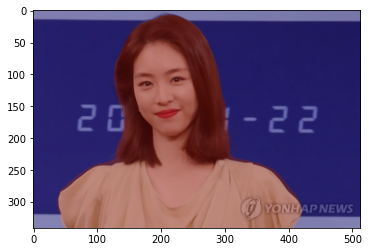

In [7]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
print(seg_map.max())
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

seg_map에는 분류한 값들이 저장될 텐데, 그 중에서 '사람'을 분류한 부분만을 남긴 후 이를 색깔로 표현하기 위해 255로 정규화했다.
`seg_map = np.where(seg_map == 15, 15, 0)` 이거는 3항연산자라서 이렇게 씀. 15인 부분은 15로 남기고 아니면 다 0으로 바꾸는 마법.
`(seg_map/seg_map.max())*255` 로 바꾸는게 더 직관적이지 않을까 싶다.
이렇게 얼굴 영역과 배경 영역을 따로 구분한 seg_map을 가지고 사진에 색칠하기 위해 `cv2.applyColorMap`을 사용한다. 

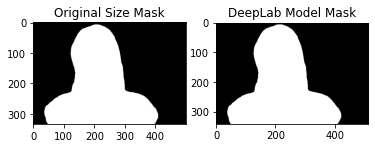

In [8]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

`img_orig.shape[:2][::-1]` 이거는 shape에서 0번째, 1번째 변수까지 쓸건데 순서를 뒤바꿔주세요 라는 의미다. resize할 때는 가로-세로가 아니라 세로-가로 순으로 들어가거든. 
그리고 DeepLab Model에서 이미지 리사이즈 된 것을 다시 원래 크기로 늘리는데, 늘리려면 중간에 없는 값들을 채워야 하니까 interpolation옵션을 주고, 여기서는 `INTER_LINEAR`를 사용하는데 '양산형 보간법'이라고 부르며 인근 4픽셀의 평균치를 사용해서 보간할 값을 생성한다. 

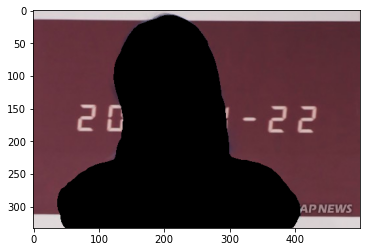

In [9]:
# 크기 늘린 마스크를 흑백으로 바꾼다. 
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
# 이거는 비트연산에서 반대로 바꿔주는 연산. 검은색 -> 하얀식으로 갈 것. 
img_bg_mask = cv2.bitwise_not(img_mask_color)
#이거는 영역에서 0이면 무시, 나머지 값은 반영한다. 
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

ERROR! Session/line number was not unique in database. History logging moved to new session 156


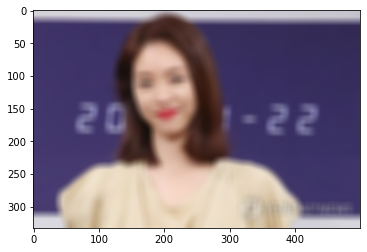

(341, 513) (341, 513, 3) (333, 500, 3) (333, 500, 3)


In [19]:
img_bg_blur = cv2.blur(img_orig, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()
print(img_mask.shape, img_resized.shape, img_bg_blur.shape, img_mask_color.shape)

해당 부분 오늘 과정과 다르게 진행했다. 누끼가 자연스럽게 따진 건 아니라서(보간법으로 경계를 생성했기 때문) 경게에 검은 선이 생겨버린다. 그래서 차라리 배경을 흐리게 해서 원본 데이터와 섞기로 했다. 

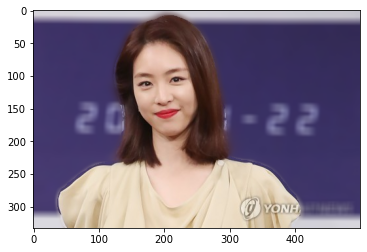

In [20]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 고양이에 대해 같은 과정 수행하기
1. 준비물 : 고양이 사진
2. 바꿔줘야 할 부분 : 아까는 sementic segmentation에서 사람 클래스를 구분했는데, 이번에는 고양이 클래스를 사용하면 된다. 

In [12]:
cat_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/lulu.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
cat_img_orig = cv2.imread(cat_img_path) 
print (cat_img_orig.shape)

(720, 1280, 3)


In [23]:
cat_img_resized, cat_seg_map = MODEL.run(cat_img_orig)
print (cat_img_orig.shape, cat_img_resized.shape, cat_seg_map.max())

(720, 1280, 3) (288, 513, 3) 8


8


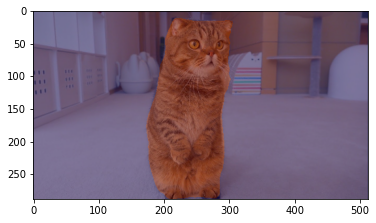

In [24]:
cat_img_show = cat_img_resized.copy()
cat_seg_map = np.where(cat_seg_map == 8, 8, 0) # 예측 중 사람만 추출
print(cat_seg_map.max())
cat_img_mask = cat_seg_map * (255/cat_seg_map.max()) # 255 normalization
cat_img_mask = cat_img_mask.astype(np.uint8)
cat_color_mask = cv2.applyColorMap(cat_img_mask, cv2.COLORMAP_JET)
cat_img_show = cv2.addWeighted(cat_img_show, 0.6, cat_color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(cat_img_show, cv2.COLOR_BGR2RGB))
plt.show()

ERROR! Session/line number was not unique in database. History logging moved to new session 157


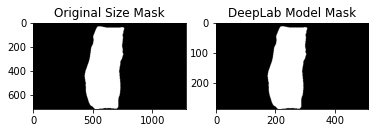

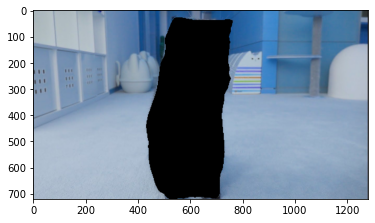

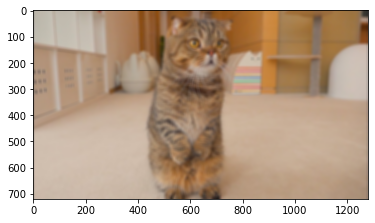

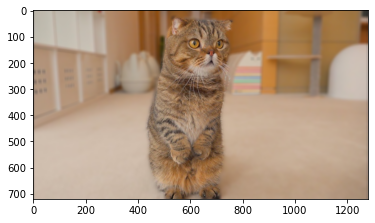

In [25]:
cat_img_mask_up = cv2.resize(cat_img_mask, cat_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, cat_img_mask_up = cv2.threshold(cat_img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(cat_img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(cat_img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

cat_img_mask_color = cv2.cvtColor(cat_img_mask_up, cv2.COLOR_GRAY2BGR)
cat_img_bg_mask = cv2.bitwise_not(cat_img_mask_color)
cat_img_bg = cv2.bitwise_and(cat_img_orig, cat_img_bg_mask)
plt.imshow(cat_img_bg)
plt.show()

cat_img_bg_blur = cv2.blur(cat_img_orig, (13,13))
plt.imshow(cv2.cvtColor(cat_img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

cat_img_concat = np.where(cat_img_mask_color==255, cat_img_orig, cat_img_bg_blur)
plt.imshow(cv2.cvtColor(cat_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 배경 합성
배경 합성은 간단하다. 저는 루루가 좋으니까 고양이 사진 편집한걸로 진행하겠습니다.

In [27]:
print(cat_img_mask_color.shape)

(720, 1280, 3)


In [28]:
back_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/background.png'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
back_img_orig = cv2.imread(back_img_path) 
print (back_img_orig.shape)

ERROR! Session/line number was not unique in database. History logging moved to new session 158
(600, 1744, 3)


In [31]:
print(back_img_orig.shape[:2][::-1])
back_img = cv2.resize(back_img_orig, cat_img_mask_color.shape[:2][::-1])
print(back_img.shape)

(1744, 600)
(720, 1280, 3)


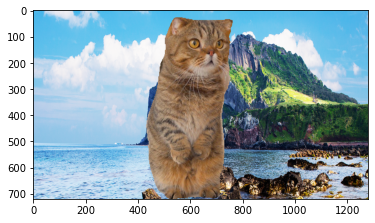

In [33]:
cat_img_back_change = np.where(cat_img_mask_color==255, cat_img_orig, back_img)
plt.imshow(cv2.cvtColor(cat_img_back_change, cv2.COLOR_BGR2RGB))
plt.show()

# 후기와 해당 방법의 고찰
Segmentation이 덩어리로 이루어지는 것 같아서 깔끔하게 경계가 따지지는 않는다. 그리고 오늘 과정에서 예시를 들었던 경우는 공교롭게도 머리 근처에 검은 물체가 있어서 이를 머리카락으로 인식한 것 같다. 이 부분에서 개선이 필요한데, 개선하려면 Watershed segmentation 말고 다른 세그멘테이션을 적용해야 할 것 같다. 또는 1차로 사물을 구분한 후에 2차로 구분한 부분에 대해서 한번 더 분류를 하면 정확도가 높아지지 않을까 하는 방안도 생각해 보았다. 

오늘 과정의 코드에서는 파이써닉하게 코드 작성하는 방법을 많이 배웠다. 이렇게 자유자재로 코드를 사용하려면 얼마나 더 해야할까? 파이썬 공부 좀 하자. 총총. 